# *Brain Tumor Classification Project - VGG19*

## 1. Import Library

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize

2025-10-16 02:21:02.107160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760581262.333659      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760581262.410731      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Data Loading

In [2]:
# Data Labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=224

for label in labels:
    path = os.path.join(train_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)

for label in labels:
    path = os.path.join(test_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [3]:
X_train.shape

(7023, 224, 224, 3)

## 3. Shuffle & split data (80%-10%-10%) 

In [4]:
from sklearn.model_selection import train_test_split

# Bước 1: shuffle & chia Train+Val (90%) và Test (10%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train,
    test_size=0.1,
    stratify=Y_train,
    random_state=42, 
    shuffle=True
)

print("Train & Val:", X_train.shape, Y_train.shape)
print("Test:", X_test.shape, Y_test.shape)

Train & Val: (6320, 224, 224, 3) (6320,)
Test: (703, 224, 224, 3) (703,)


In [5]:
# Bước 2: chia Train (80%) và Validation (10%)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train,
    test_size=0.1111,   # ≈10% tổng dataset
    stratify=Y_train,
    random_state=42,
    shuffle=True
)

# Kiểm tra kích thước
print("Train:", X_train.shape, Y_train.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Test:", X_test.shape, Y_test.shape)

Train: (5617, 224, 224, 3) (5617,)
Validation: (703, 224, 224, 3) (703,)
Test: (703, 224, 224, 3) (703,)


In [6]:
# Kiểm tra dtype
print("Train:", X_train.dtype, Y_train.dtype)
print("Validation:", X_val.dtype, Y_val.dtype)
print("Test:", X_test.dtype, Y_test.dtype)

Train: float64 int64
Validation: float64 int64
Test: float64 int64


## 4. Data preprocessing

### 4.1 Data standardization

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import preprocess_input

In [8]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# Y_train_cat = to_categorical(Y_train, num_classes=4)
# Y_val_cat = to_categorical(Y_val, num_classes=4)
# Y_test_cat = to_categorical(Y_test, num_classes=4)

In [9]:
print("Min pixel:", X_train.min())
print("Max pixel:", X_train.max())

Min pixel: 0.0
Max pixel: 1.0


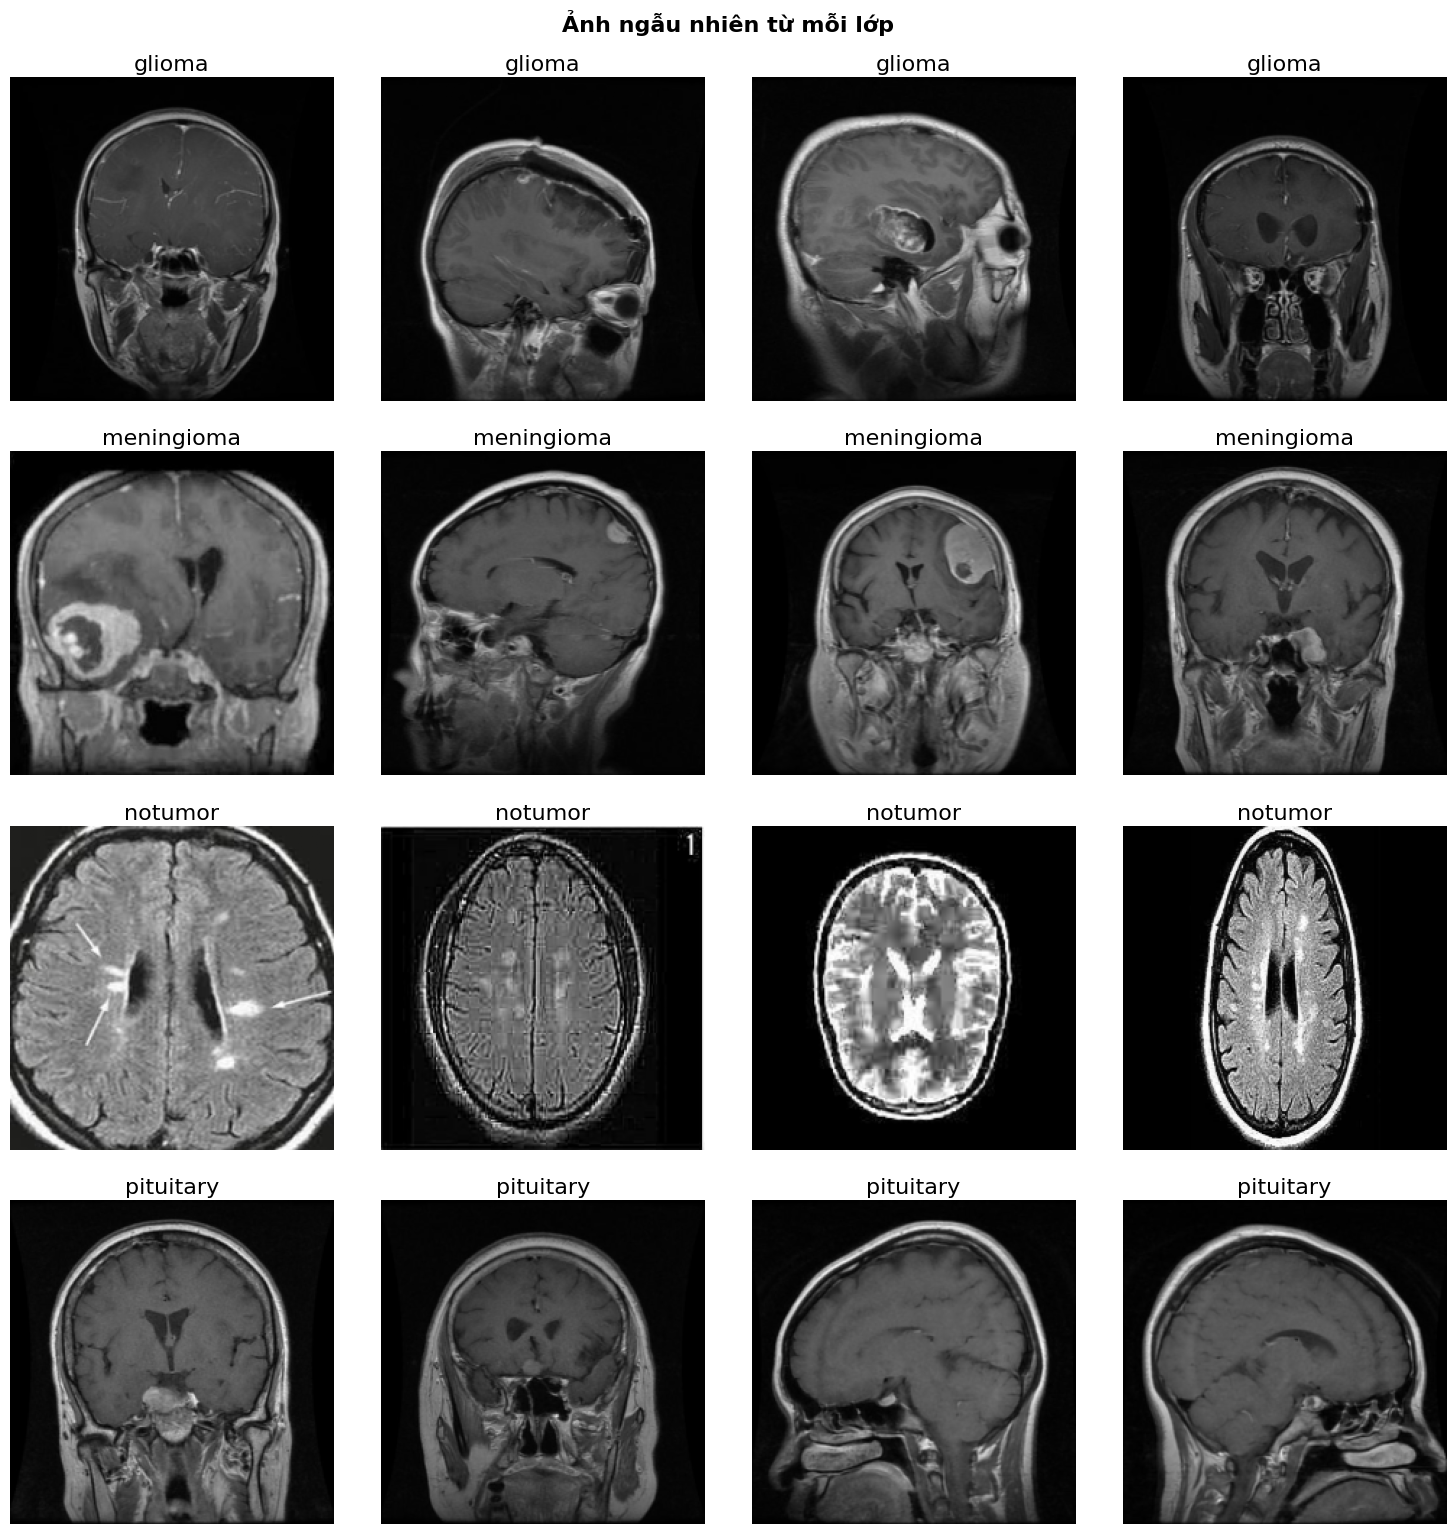

In [10]:
num_samples = 4  # số ảnh mỗi lớp
plt.figure(figsize=(15, 15))

for class_idx, label in enumerate(labels):
    # Lấy index ảnh thuộc lớp này
    idxs = np.where(Y_train == class_idx)[0]
    # Chọn ngẫu nhiên
    sample_idxs = np.random.choice(idxs, num_samples, replace=False)

    for i, idx in enumerate(sample_idxs):
        plt.subplot(len(labels), num_samples, class_idx * num_samples + i + 1)
        plt.imshow(X_train[idx])
        plt.axis("off")
        plt.title(label, fontsize=16, pad=5)

plt.tight_layout(h_pad=2.0)
plt.suptitle("Ảnh ngẫu nhiên từ mỗi lớp", fontsize=16, fontweight="bold", y=1.02)
plt.show()

### 4.2 Data augmentation with generator

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocess_input(x * 255.0),
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=None,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocess_input(x * 255.0)
)
test_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocess_input(x * 255.0)
)

BATCH_SIZE = 32

train_generator = train_datagen.flow(
    X_train, Y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, Y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = test_datagen.flow(
    X_test, Y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

### 4.4 Show Generator

In [12]:
X_batch, Y_batch = next(train_generator)
print("Image shape:", X_batch.shape)
print("Min pixel:", X_batch.min())
print("Max pixel:", X_batch.max())

Image shape: (32, 224, 224, 3)
Min pixel: -123.68
Max pixel: 151.061


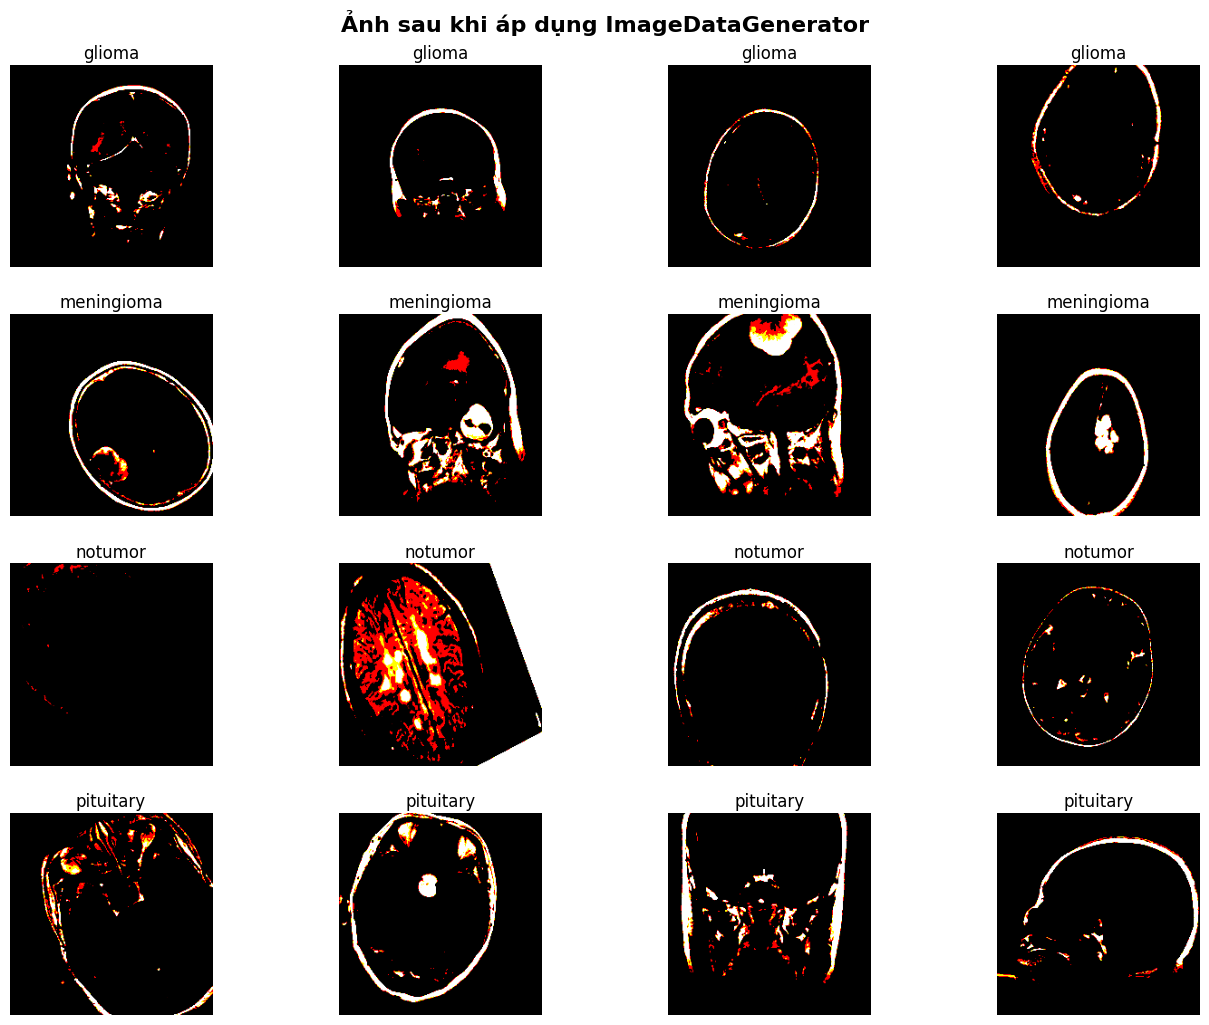

In [13]:
num_samples = 4
batch_x, batch_y = next(train_generator)

# Nếu Y là one-hot, chuyển lại thành chỉ số lớp
if batch_y.ndim > 1:
    batch_y = np.argmax(batch_y, axis=1)

# Lấy danh sách các nhãn (label) — ví dụ: ['glioma', 'meningioma', 'notumor', 'pituitary']
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

plt.figure(figsize=(14, 10))
for class_idx, label in enumerate(labels):
    # Tìm ảnh thuộc lớp này
    idxs = np.where(batch_y == class_idx)[0]
    # Chọn ngẫu nhiên tối đa num_samples ảnh
    sample_idxs = np.random.choice(idxs, min(num_samples, len(idxs)), replace=False)

    for i, idx in enumerate(sample_idxs):
        plt.subplot(len(labels), num_samples, class_idx * num_samples + i + 1)
        plt.imshow(np.clip(batch_x[idx], 0, 1))  # đảm bảo hiển thị đúng
        plt.axis("off")
        plt.title(label, fontsize=12, pad=4)

plt.tight_layout(h_pad=2.0)
plt.suptitle("Ảnh sau khi áp dụng ImageDataGenerator", fontsize=16, fontweight="bold", y=1.02)
plt.show()


## 5. Train Data with VGG19

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall

In [15]:
# -------------------------
# class weights (nếu cần)
# -------------------------
y_train = Y_train 
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {int(k): float(v) for k, v in zip(classes, class_weights)}
print("class_weights:", class_weights)

# -------------------------
# Build model (base + head)
# -------------------------
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4

base_model = VGG19(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# build head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
# -------------------------
# callbacks
# -------------------------
callbacks = [
    ModelCheckpoint('vgg19.h5', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# freeze backbone
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

# Fit 
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights,  
    verbose=1
)

class_weights: {0: 1.0826908249807248, 1: 1.06787072243346, 2: 0.87765625, 3: 0.9994661921708186}


I0000 00:00:1760581470.111584      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760581470.112257      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1760581475.694924      66 service.cc:148] XLA service 0x797a0c0074a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760581475.696140      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760581475.696163      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760581476.166016      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/176 ━━━━━━━━━━━━━━━━━━━━ 43:47 15s/step - accuracy: 0.2812 - loss: 3.5903

I0000 00:00:1760581487.843006      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.3766 - loss: 3.2086
Epoch 1: val_loss improved from inf to 1.07171, saving model to vgg19.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 502ms/step - accuracy: 0.3772 - loss: 3.2047 - val_accuracy: 0.7326 - val_loss: 1.0717 - learning_rate: 1.0000e-04
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6246 - loss: 1.4919
Epoch 2: val_loss improved from 1.07171 to 0.88266, saving model to vgg19.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 391ms/step - accuracy: 0.6248 - loss: 1.4912 - val_accuracy: 0.8065 - val_loss: 0.8827 - learning_rate: 1.0000e-04
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7097 - loss: 1.1194
Epoch 3: val_loss improved from 0.88266 to 0.82357, saving model to vgg19.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 390ms/step - accuracy: 0.7097 - loss: 1.1193 - val_accuracy: 0.8236 - val_loss: 0.8236 - learning_rate: 1.0000e-04
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7371 - 

## 6. Evaluation & Report

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

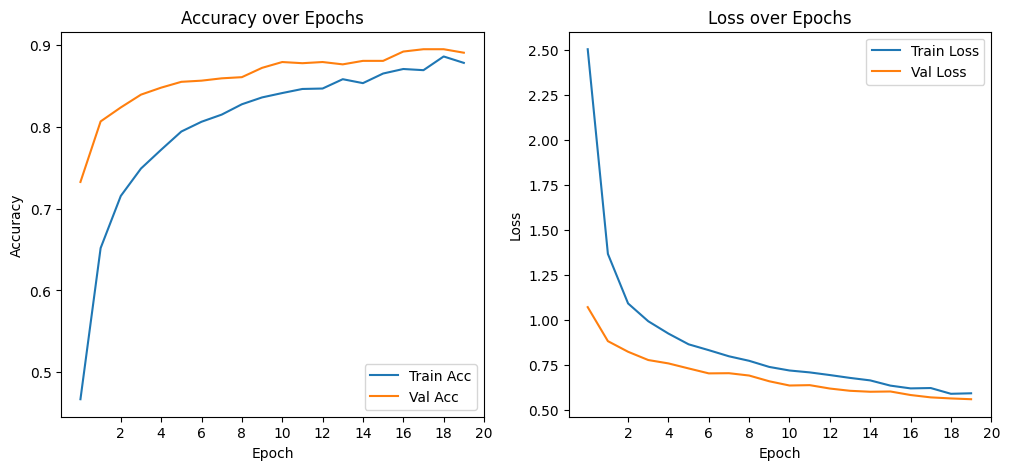

In [17]:
epochs = len(history.history['accuracy'])
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(np.arange(2, epochs+1, 2))

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(2, epochs+1, 2))

plt.show()



In [18]:
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy (from model.evaluate): {acc*100:.2f}%\n")

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.8814 - loss: 0.5429

 Test Accuracy (from model.evaluate): 88.90%



In [19]:
# Dự đoán trên test 
model.load_weights('vgg19.h5')
y_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# lấy true labels 
y_true = Y_test

acc = accuracy_score(y_true, y_pred)
print(f"\n Test Accuracy: {acc*100:.2f}%\n")

print(classification_report(y_true, y_pred, target_names=labels))
cm = confusion_matrix(y_true, y_pred)

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step

 Test Accuracy: 88.90%

              precision    recall  f1-score   support

      glioma       0.87      0.85      0.86       162
  meningioma       0.78      0.84      0.81       165
     notumor       0.99      0.90      0.94       200
   pituitary       0.91      0.95      0.93       176

    accuracy                           0.89       703
   macro avg       0.89      0.89      0.89       703
weighted avg       0.89      0.89      0.89       703



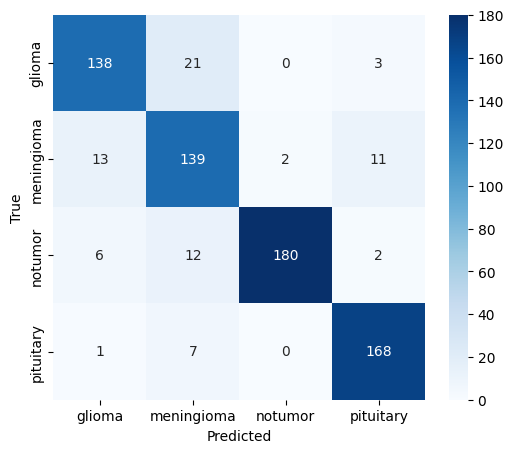

In [20]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()